# High School Choice
## *How a k-means clustering algorithm might come in handy*

#### By Wouter Bouma

#  
##### Note: Opening this file in a browser other than Chrome may result in the maps not rendering!

### Introduction

When children reach the age they go to high school or move to another city parents have to deal with an important decision: **which school should I choose for my child?**  

Obviously parents will look at the schools' quality of education and probably take into account the travel distance as well. However, when children go into puberty you also want to protect them being exposed to unhealthy temptations in the world out there. Especially those that may exist in the immediate vicinity of the school.  

Wouldn't it be nice to cluster schools based on the type and number of predefined 'bad locations' in their near vicinity and visualize these on a map?  
In the next sections we show how Foursquare and a clustering algorithm called K-means can be of assistence.


### Data

##### What is Foursquare?

Foursquare is a location-based social network (LBSN) that allows people to share their location with friends by ‘checking-in’ at a given place using their smartphone. The application can also access the location-based recommendations left by other users. Foursquare has tens of millions of users and a huge database containing information on both venues and users. Including detailed information on users preferences, tips, menus, photo's, location, categories etc.
Fortunately Foursquare has an API (Application Program Interface) which allow us to retrieve information from their database efficiently.

##### How to get information from Foursquare?
There are multiple ways of calling Foursqaures api (endpoints) where each endpoint has different inputparameters and returns different kind of information. 

For this purpose I use the *explore* endpoint which returns the venues within a certain radius of a location provided as inputparameters (lattitude and longitude) in the API call. In this api we can (but don't have to) provide one or more category id's which ensures we only get returned venues of a certain type (category). 

More information on the input and output of the explore endpoint api can be found [here](https://developer.foursquare.com/docs/api-reference/venues/explore/):   
More information on the categories can be found [here](https://developer.foursquare.com/docs/build-with-foursquare/categories/)

The api will return 100 results as a maximum per call. Using the offset parameter in the call we can do multiple calls to get the next 100 results until we have reached the total number of results.

#####  The general approach

* First, we determine all the names and locations of all high schools within a certain given radius of a certain location. For our example we have choosen a radius of **30 km** and **Chicago** as its center. Hereto we call the Foursquare API using its explore endpoint providing radius, location and the **high school category id** as input.


* Next, we call the API for each school returned in the previous step seperately. But now we use the category id's we have defined as being 'bad locations' within a radius of **1 km** of the school. For our example we have choosen the following categories:
> * **Fast Food Restaurants**
> * **Liquor stores**
> * **Gun shops**

> *At a later stage will be explained how weigths can be applied to the categories. The existence of a gun shop  should probably have a bigger impact than a fast food restaurant when classifying schools in terms of the 'safeness' of the school's neighborhood with respect to these categories.*

* Finally we use the retrieved data to perform to cluster schools based on their similarity given the type and number of bad locations in their vicinity.

In the next section we go into the details of each of these steps


### Methodology

First we import the necassary libraries

In [2]:
import pandas as pd
import numpy as np

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json

Next we determine the location to examine.

In [3]:
address = 'Chicago'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
locationLat = location.latitude
locationLon = location.longitude
print('The geograpical coordinates of Chicago are {}, {}.'.format(locationLat, locationLon))


The geograpical coordinates of Chicago are 41.8755616, -87.6244212.


Below we create url for the Foursquare API call to determine the high schools in a 30km radius of this location

In [4]:

CLIENT_ID = 'W3GBMV2TBYXHDKZLEHAT1FISU2HS12CZBNMMAWRNTHEOWJYY' 
CLIENT_SECRET = 'CYTFPE31SS30UG2XEIAS5DNLOWTABZLYRXCCW5AIE1JCB1NV' 

In [5]:
LIMIT = 10000 # limit of number of venues returned by Foursquare API
VERSION = '20180605' # Foursquare API version
radius = 30000 # define radius

categoryId = '4bf58dd8d48988d13d941735' #high school

# create the API request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
CLIENT_ID, 
CLIENT_SECRET, 
VERSION, 
locationLat, 
locationLon, 
radius, 
categoryId,
LIMIT)

The schools details are in the items section (part of groups which is part of response). Moreover we see that the total results are 176 high schools (of which in this single call only 100 are returned).

In [6]:
numberOfSchools = requests.get(url).json()["response"]['totalResults']
numberOfSchools

176

Below we create a function that takes coordinates and a radius as parameters and iteratively call the API to ensure all results are fetched (using the offset parameter mentioned before). The function returns a dataframe containing the total number of the school's including their names and locations (lattitude and longitude).

In [7]:
def getSchools(lat, long, radius):
    

    VERSION = '20200401' # Foursquare API version
    LIMIT = 50000 
    
    categoryId = '4bf58dd8d48988d13d941735' #high schools
    offset = 0
    
    school_list=[]

    #first call
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}&sortByDistance=1&offset={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    long, 
    radius, 
    categoryId,
    LIMIT,
    offset)
            
    # make the GET request
    totalNumberOfSchools = requests.get(url).json()["response"]['totalResults'] #get total results
    schools = requests.get(url).json()["response"]['groups'][0]['items'] #get venues of category High School
        
    # return only relevant information for each school
    school_list.append([(
    s['venue']['name'], 
    s['venue']['location']['lat'], 
    s['venue']['location']['lng']) for s in schools])
    
  
    #create dataframe of results
    schools_df = pd.DataFrame([item for school in school_list for item in school])
    schools_df.columns = ['Name', 
                  'Latitude', 
                  'Longitude']
    
    # Consecutive calls
    while schools_df.Name.count() < totalNumberOfSchools:
        offset += 100 #increase by 100 to get next 100 results
        school_list.clear() # start with empty list for each iteration
        
        #call api again now using offset
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}&sortByDistance=1&offset={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius, 
        categoryId,
        LIMIT,
        offset)
            
        # Get results again
        #totalNumberOfSchools = requests.get(url).json()["response"]['totalResults'] #get total results
        schools = requests.get(url).json()["response"]['groups'][0]['items'] #get venues of category High School
        
        # return only relevant information for each school
        school_list.append([(
        s['venue']['name'], 
        s['venue']['location']['lat'], 
        s['venue']['location']['lng']) for s in schools])
    
        # store results in dataframe and append to previous results 
        schools_df_temp = pd.DataFrame([item for school in school_list for item in school])
        
        schools_df_temp.columns = ['Name', 
                              'Latitude', 
                              'Longitude']
      
        # Append to dataframe
        schools_df = schools_df.append(schools_df_temp,sort=False,ignore_index=True) 

    
        
    return(schools_df)

Call the function

In [8]:
dfSchools = getSchools(locationLat,locationLon,30000)

Now check if we have all schools

In [9]:
dfSchools.shape

(176, 3)

And what the returned dataframe looks like

In [10]:
dfSchools.head()

,Name,Latitude,Longitude
0,Jones College Prep,41.873561,-87.627558
1,Innovations High School,41.882640,-87.626343
2,"The British International School of Chicago, S...",41.870491,-87.632715
3,The Dance Center (DE),41.865597,-87.624243
4,Harold Washington College,41.886126,-87.626868


#### Next, let's see where the schools are located on a map (without any clustering yet)

In [11]:
# create map of New York using latitude and longitude values
mapSelected = folium.Map(location=[locationLat, locationLon], zoom_start=10)

# add markers to map
for lat, lng, name in zip(dfSchools['Latitude'], dfSchools['Longitude'], dfSchools['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapSelected)  
    
mapSelected

#### Similarly we create a function to search for liquor stores, gun shops and fastfood restaurants for each school
This function takes the schools name and their coordinates as parameters and returns an enriched dataframe containing the bad locations.
The category id's were retrieved [here](https://developer.foursquare.com/docs/build-with-foursquare/categories/).

In [12]:
def getNearbyBadSpots(names, latitudes, longitudes, radius=1000):
    
    LIMIT = 1000 
    categoryList = ['52f2ab2ebcbc57f1066b8b19','4bf58dd8d48988d16e941735','4bf58dd8d48988d186941735']
  
    badSpot_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId=52f2ab2ebcbc57f1066b8b19,4bf58dd8d48988d116941735,4bf58dd8d48988d16e941735,4bf58dd8d48988d186941735&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        #print(requests.get(url).raise_for_status())
        badSpots = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        badSpot_list.append([(
            name, 
            lat, 
            lng, 
            b['venue']['name'], 
            b['venue']['location']['lat'], 
            b['venue']['location']['lng'],  
            b['venue']['categories'][0]['name'],
            b['venue']['categories'][0]['id']) for b in badSpots])

    nearby_badSpots = pd.DataFrame([item for badSpot_list in badSpot_list for item in badSpot_list])
    nearby_badSpots.columns = ['School', 
                  'SchoolLatitude', 
                  'SchoolLongitude', 
                  'BadSpot', 
                  'BadSpotLatitude', 
                  'BadSpotLongitude', 
                  'BadSpotCategory',
                  'BadSpotID']
    
    nearby_badSpots= nearby_badSpots[nearby_badSpots.BadSpotID.isin(categoryList)]
    
    return(nearby_badSpots)



Let's apply this function to get all the 'bad locations' per school

In [13]:
dfSchoolsWithBadSpots = getNearbyBadSpots(names=dfSchools['Name'],
                        latitudes=dfSchools['Latitude'],
                        longitudes=dfSchools['Longitude'],
                        radius=1000)

Let's look at the first 20 rows of the dataframe

In [14]:
dfSchoolsWithBadSpots.head(15)

,School,SchoolLatitude,SchoolLongitude,BadSpot,BadSpotLatitude,BadSpotLongitude,BadSpotCategory,BadSpotID
0,Jones College Prep,41.873561,-87.627558,Warehouse Liquors,41.873375,-87.626033,Liquor Store,4bf58dd8d48988d186941735
1,Jones College Prep,41.873561,-87.627558,Five Guys,41.867835,-87.626060,Fast Food Restaurant,4bf58dd8d48988d16e941735
3,Jones College Prep,41.873561,-87.627558,Taco Bell,41.876464,-87.629413,Fast Food Restaurant,4bf58dd8d48988d16e941735
4,Jones College Prep,41.873561,-87.627558,Subway,41.874957,-87.626122,Fast Food Restaurant,4bf58dd8d48988d16e941735
6,Jones College Prep,41.873561,-87.627558,Jimmy John's,41.878300,-87.627815,Fast Food Restaurant,4bf58dd8d48988d16e941735
7,Jones College Prep,41.873561,-87.627558,Subway,41.867155,-87.624409,Fast Food Restaurant,4bf58dd8d48988d16e941735
9,Jones College Prep,41.873561,-87.627558,Subway,41.876720,-87.628954,Fast Food Restaurant,4bf58dd8d48988d16e941735
10,Jones College Prep,41.873561,-87.627558,Subway,41.877389,-87.628440,Fast Food Restaurant,4bf58dd8d48988d16e941735
13,Jones College Prep,41.873561,-87.627558,Subway,41.877045,-87.635270,Fast Food Restaurant,4bf58dd8d48988d16e941735
14,Jones College Prep,41.873561,-87.627558,Subway,41.878374,-87.627904,Fast Food Restaurant,4bf58dd8d48988d16e941735


Below we create a dataframe with a separate columns for each category and see the first 10 rows

In [15]:
# one hot encoding
dfSchoolsWithBadSpots_onehot = pd.get_dummies(dfSchoolsWithBadSpots[['BadSpotCategory']], prefix="", prefix_sep="")

# add schoolname column back to dataframe
dfSchoolsWithBadSpots_onehot['School'] = dfSchoolsWithBadSpots['School'] 

# move School column to the first column
fixed_columns = [dfSchoolsWithBadSpots_onehot.columns[-1]] + list(dfSchoolsWithBadSpots_onehot.columns[:-1])
dfSchoolsWithBadSpots_onehot = dfSchoolsWithBadSpots_onehot[fixed_columns]

dfSchoolsWithBadSpots_onehot.head(10)


,School,Fast Food Restaurant,Gun Shop,Liquor Store
0,Jones College Prep,0,0,1
1,Jones College Prep,1,0,0
3,Jones College Prep,1,0,0
4,Jones College Prep,1,0,0
6,Jones College Prep,1,0,0
7,Jones College Prep,1,0,0
9,Jones College Prep,1,0,0
10,Jones College Prep,1,0,0
13,Jones College Prep,1,0,0
14,Jones College Prep,1,0,0


And sum the resulting numbers to have a unique row per school in a new dataframe

In [16]:
pd.set_option('display.max_rows',10)
dfSchoolsWithBadSpots_grouped = dfSchoolsWithBadSpots_onehot.groupby('School').sum().reset_index()
dfSchoolsWithBadSpots_grouped

,School,Fast Food Restaurant,Gun Shop,Liquor Store
0,Al Raby High School,3,0,2
1,Alan B Shepard High School,1,0,0
2,Amos Alonzo Stagg High School,3,0,0
3,Amundsen High School,11,0,9
4,Aspira Mirta Ramirez Computer Science High School,9,0,8
...,...,...,...,...
160,Willowbrook High School,7,0,2
161,Wolcott School,7,0,4
162,York High School,5,1,0
163,photography dark room,9,0,0


Now we can give some relative weight to each category: how important (ie concerning) is each category? (equal values means equal importance, a higher relative value means more importance/concern). In our example we give fastfood restaurants weight 1, liquor stores weight 2 and gun shops a weight of 20.
Effectively this means we find 1 nearby gun shop the equivalent of 20 nearby fast food restaurants and 10 nearby liquor stores

In [17]:
pd.set_option('display.max_rows',10)
dfSchoolsWithBadSpots_grouped_weighted = dfSchoolsWithBadSpots_grouped

liquorWeight = 2
fastfoodWeight = 1
gunWeight = 20

dfSchoolsWithBadSpots_grouped_weighted['Liquor Store'] = dfSchoolsWithBadSpots_grouped['Liquor Store']*liquorWeight
dfSchoolsWithBadSpots_grouped_weighted['Fast Food Restaurant'] = dfSchoolsWithBadSpots_grouped['Fast Food Restaurant']*fastfoodWeight
dfSchoolsWithBadSpots_grouped_weighted['Gun Shop'] = dfSchoolsWithBadSpots_grouped['Gun Shop']*gunWeight

dfSchoolsWithBadSpots_grouped_weighted

,School,Fast Food Restaurant,Gun Shop,Liquor Store
0,Al Raby High School,3,0,4
1,Alan B Shepard High School,1,0,0
2,Amos Alonzo Stagg High School,3,0,0
3,Amundsen High School,11,0,18
4,Aspira Mirta Ramirez Computer Science High School,9,0,16
...,...,...,...,...
160,Willowbrook High School,7,0,4
161,Wolcott School,7,0,8
162,York High School,5,20,0
163,photography dark room,9,0,0


Look at the total number of unique school names

In [18]:
dfSchoolsWithBadSpots_grouped_weighted.School.unique().shape[0]


165

This number differs from our original total number of schools. This is the result of schools that did not return any 'bad location' in the api call. Let's add these missing schools to the dataframe with a value of 0 for each category.

In [19]:
missingSchools = dfSchools[~dfSchools.Name.isin(dfSchoolsWithBadSpots_grouped_weighted.School.unique())]
numberMissing = missingSchools.Name.count()

#Create dataframe with 0 values for missing schools
if numberMissing > 0:
    listMissingSchools = list(missingSchools['Name'])
    toAppend = {'School':  listMissingSchools,
            'Fast Food Restaurant': np.repeat([0],numberMissing),
            'Gun Shop': np.repeat([0],numberMissing),
            'Liquor Store': np.repeat([0],numberMissing)}
    toAppend = pd.DataFrame(toAppend)
    dfSchoolsWithBadSpots_grouped_weighted=dfSchoolsWithBadSpots_grouped_weighted.append(toAppend,sort=False,ignore_index=True) 



#### It looks like we have a dataframe that we can work with for our clustering analysis now

In [20]:
dfSchoolsWithBadSpots_grouped_weighted

,School,Fast Food Restaurant,Gun Shop,Liquor Store
0,Al Raby High School,3,0,4
1,Alan B Shepard High School,1,0,0
2,Amos Alonzo Stagg High School,3,0,0
3,Amundsen High School,11,0,18
4,Aspira Mirta Ramirez Computer Science High School,9,0,16
...,...,...,...,...
170,Nazareth High School,0,0,0
171,Hinsdale Central High School,0,0,0
172,East Chicago Central High School,0,0,0
173,Bremen High School,0,0,0


#### K-means
K-means is a clustering algorithm that clusters datapoints based on their similarity. Similarity is measured in terms of the 'distances' between each datapoint. It iteratively assignes datapoints to their nearest cluster centerpoint ensuring datapoints are assigned to a cluster as close as possible to datapoints assigned to the same cluster and as far away as possible to datapoints assigned to another cluster. 

In our case it means that similarity is measured as the difference in the **weighted** number of fastfood restaurants, liquor stores and gun shops.

We use the so called elbow technique to find the optimal number of clusters (which is required to provide to the k-means function manually). 

In [21]:
#Elbow technique
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dfSchoolsWithBadSpots_grouped_weighted.drop('School', 1))
    Sum_of_squared_distances.append(km.inertia_)

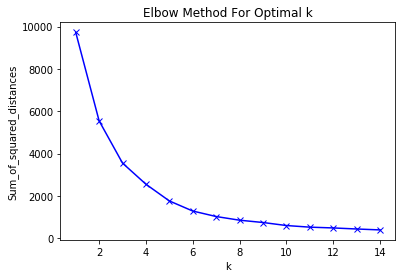

In [22]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Allthough not very clear in this case we choose 5 to be te optimal number for k. 
In the code below we determine the cluster for each school based on k = 5 and add the clusters to the dataframe.

In [23]:
# set number of clusters
kclusters = 5

schools_grouped_clustering = dfSchoolsWithBadSpots_grouped_weighted.drop('School', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(schools_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 1, 1, 2, 2, 2, 2, 0], dtype=int32)

In [24]:
dfSchoolsWithBadSpots_grouped_weighted.insert(0, 'Cluster Labels', kmeans.labels_)


# merge dfSchools with fSchoolsWithBadSpots_grouped_weighted to add latitude/longitude for each school
dfFinal = pd.merge(dfSchools, dfSchoolsWithBadSpots_grouped_weighted, left_on='Name', right_on='School')

Let's look what our dataframe looks like now

In [25]:
dfFinal.head()

,Name,Latitude,Longitude,Cluster Labels,School,Fast Food Restaurant,Gun Shop,Liquor Store
0,Jones College Prep,41.873561,-87.627558,3,Jones College Prep,35,0,6
1,Innovations High School,41.882640,-87.626343,3,Innovations High School,35,0,0
2,"The British International School of Chicago, S...",41.870491,-87.632715,3,"The British International School of Chicago, S...",33,0,10
3,The Dance Center (DE),41.865597,-87.624243,2,The Dance Center (DE),9,0,6
4,Harold Washington College,41.886126,-87.626868,3,Harold Washington College,32,0,4


We see we have redundant school columns so delete one

In [26]:
dfFinal= dfFinal.drop('School',1)

#### Before plotting on a map let's take a look at the meaning of the clusters using a 3d graph

In [27]:
import sys
!conda install --yes --prefix {sys.prefix} plotly

Solving environment: done

# All requested packages already installed.



In [40]:
import plotly as pl
import plotly.graph_objects as go
import plotly.express as px


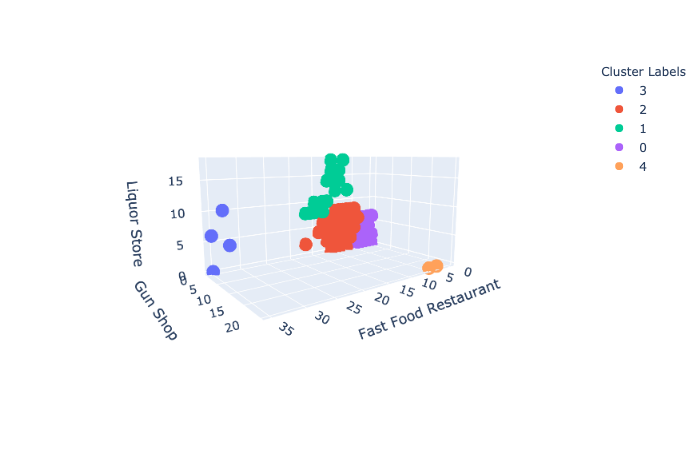

In [71]:
df = dfFinal
df['Cluster Labels'] = df['Cluster Labels'].astype(str)
fig = px.scatter_3d(df, x='Fast Food Restaurant', y='Gun Shop', z='Liquor Store',
              color='Cluster Labels')
name = 'eye = (x:2, y:2, z:0.1)'
camera = dict(
    eye=dict(x=1.5, y=2, z=0.4)
)
fig.update_layout(scene_camera=camera)
fig.show(renderer="png")

We see that the datapoints are clearly clustered based on their similarities.
Turning the graph and hovering over and zooming in to the datapoints we can disinguish the following clusters:
> * Cluster 0: Low number of all 'bad locations'
> * Cluster 1: Some fastfood restaurants but high number of liquor stores, no gun shops
> * Cluster 2: Some fastfood restaurants and some liquor stores, no gun shops
> * Cluster 3: High number of fastfoodrestaurants, some liquor stores, no gun shops
> * Cluster 4: Low number of fastfood restaurants and no liquor stores and high number of gun shops, 

In [30]:
dfFinal

,Name,Latitude,Longitude,Cluster Labels,Fast Food Restaurant,Gun Shop,Liquor Store
0,Jones College Prep,41.873561,-87.627558,3,35,0,6
1,Innovations High School,41.882640,-87.626343,3,35,0,0
2,"The British International School of Chicago, S...",41.870491,-87.632715,3,33,0,10
3,The Dance Center (DE),41.865597,-87.624243,2,9,0,6
4,Harold Washington College,41.886126,-87.626868,3,32,0,4
...,...,...,...,...,...,...,...
171,The Harold G. Baer Natatorium (Pool),42.019987,-87.906867,0,3,0,2
172,Maine West High School Campus,42.024354,-87.878265,0,1,0,6
173,youth connection charter school,41.751500,-87.641909,2,6,0,4
174,UNO Soccer Academy High School,41.802036,-87.710527,0,2,0,0


#### Let's plot the results on a map

In [31]:
# create map
map_clusters = folium.Map(location=[locationLat, locationLon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfFinal['Latitude'], dfFinal['Longitude'], dfFinal['Name'], dfFinal['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Results

Clicking on the schools locations we see which clusters are associated with each color:
* Cluster 0 - red
* Cluster 1 - purple
* Cluster 2 - blue
* Cluster 3 - green
* Cluster 4 - orange

Based on this plot we can conclude that:
* The 'safest' school (cluster 0, marked red) based on the chosen categories are located away from the city center.
* There is a high number of both fastfood restaurants and liquor stores near schools north of Chicago's city centre (cluster 1, marked purple)
* The concentration of fastfood restaurants and liquor stores seems to decrease as the distance from the city centre increases (compare cluster 2, marked blue with cluster 0 marked red)
* A high concentration of fastfood restaurants near schools are in the city centre (cluster 3, marked green)
* Two schools are near gun shops (cluster 4, marked orange). Probably the same gun shop causing both schools to be clustered like this though

### Discussion

We have been able to cluster schools based on the vicinity of nearby venue types. This may be helpful for parents in their choice of high school. Especially when new to a city or neighborhood. We must note that we have been able to clearly visualize how clusters were formed since we used three categories. When using more categories this might become less transparant. 

To expand on this idea we might think of an application where the user enters it's location, search radius and categories himself. For people living in Las Vegas the vicinity of casino's and betting stores might be the categories of concern they want the clustering to be based on. And in countries outside the US gun shops might not be an issue at all. 
Besides that we can also perform a similar analysis based on 'good' categories (eg. the vicinity of healthy food shops and sport locations). However, retrieving the locations from the API sometimes prove to be instable and too slow for a good user experience.

Finally, this application can prove to be helpful to analyse whether there is a correlation between crimes, violations or accidents involving students from high schools and the vicinity of certain venue types.

### Conclusion

We have proven that schools can be clustered using Phyton and its libraries, the Foursquare API and the k-means algorithm.

Hopefully this idea and code inspires others to think of future applications using Foursquare data and clustering to help solving real life challenges.